To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

**NEW** Unsloth now supports training the new **gpt-oss** model from OpenAI! You can start finetune gpt-oss for free with our **[Colab notebook](https://x.com/UnslothAI/status/1953896997867729075)**!

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Gemma 3N Guide](https://docs.unsloth.ai/basics/gemma-3n-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


#### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth

#### Unsloth

In [1]:
cache_dir = "/scratch/.../models"

In [ ]:
import yaml

with open("qwen14b_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [2]:
from unsloth import FastLanguageModel
import torch

fourbit_models = [
    "unsloth/Qwen3-1.7B-unsloth-bnb-4bit", # Qwen 14B 2x faster
    "unsloth/Qwen3-4B-unsloth-bnb-4bit",
    "unsloth/Qwen3-8B-unsloth-bnb-4bit",
    "unsloth/Qwen3-14B-unsloth-bnb-4bit",
    "unsloth/Qwen3-32B-unsloth-bnb-4bit",

    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/Phi-4",
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/orpheus-3b-0.1-ft-unsloth-bnb-4bit" # [NEW] We support TTS models!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = config["model"],
    max_seq_length = config["max_seq_len"],   # Context length - can be longer, but uses more memory
    load_in_4bit = True,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    # token = "hf_...",      # use one if using gated models
    cache_dir=cache_dir
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.6: Fast Qwen3 patching. Transformers: 4.55.2.
   \\   /|    NVIDIA RTX 6000 Ada Generation. Num GPUs = 1. Max memory: 47.383 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.41G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"],
                      # "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.8.6 patched 28 layers with 28 QKV layers, 28 O layers and 0 MLP layers.


<a name="Data"></a>
### Data Prep
Qwen3 has both reasoning and a non reasoning mode. So, we should use 2 datasets:

1. We use the [Open Math Reasoning]() dataset which was used to win the [AIMO](https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-2/leaderboard) (AI Mathematical Olympiad - Progress Prize 2) challenge! We sample 10% of verifiable reasoning traces that used DeepSeek R1, and whicht got > 95% accuracy.

2. We also leverage [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k) dataset in ShareGPT style. But we need to convert it to HuggingFace's normal multiturn format as well.

In [4]:
from datasets import load_dataset
dataset = load_dataset(
    "causality-grammar/logic_explanations",
    data_files={"train": "Baselines/Data/Train/deepseek_5k_RP.parquet",
                "test": "Baselines/Data/Test/deepseek_2k_RP_test.parquet"}
)

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
def generate_conversation(examples):
  questions  = examples["Question"]
  proof_chains = examples["Complex_CoT"]
  final_answers = examples["Response"]
  # conversations = []
  # for question, proof_chain, final_answer in zip(questions, proof_chains, final_answers):
  user = f"Answer the question based on the provided context.\n\nYour Final answer should be 0 (if False) and 1 (if True)\n\nQuestion: {questions}\n\nAnswer:"
  assistant = f"{proof_chains}\n\nFinal Answer: {final_answers}"
  conversation = [
      {"role" : "user",      "content" : user},
      {"role" : "assistant", "content" : assistant},
  ]
  return {"conversation": conversation}

In [6]:
conversations = tokenizer.apply_chat_template(
    dataset["train"].map(generate_conversation, batched=False)["conversation"],
    tokenize = False,
)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [7]:
print(conversations[34000])

<|im_start|>user
Answer the question based on the provided context.

Your Final answer should be 0 (if False) and 1 (if True)

Question: Facts:  Alice is helpless [PERIOD] Alice is troubled [PERIOD] Alice is unpleasant [PERIOD] Alice is blushing [PERIOD]
Rules:
elegant [IMPLY] difficult [PERIOD]
charming [IMPLY] excited [PERIOD]
excited [IMPLY] zealous [PERIOD]
excited [IMPLY] troubled [PERIOD]
confident [AND] difficult [IMPLY] gleaming [PERIOD]
charming [AND] clumsy [AND] elegant [IMPLY] confident [PERIOD]
difficult [IMPLY] fragile [PERIOD]
troubled [AND] excited [AND] witty [IMPLY] helpless [PERIOD]
attractive [AND] unpleasant [IMPLY] confident [PERIOD]
troubled [AND] unpleasant [AND] gleaming [IMPLY] helpless [PERIOD]
fragile [AND] long [AND] helpless [IMPLY] difficult [PERIOD]
blushing [AND] confident [AND] attractive [IMPLY] clumsy [PERIOD]
clumsy [AND] troubled [AND] zealous [IMPLY] distinct [PERIOD]
long [AND] unpleasant [IMPLY] charming [PERIOD]
excited [IMPLY] witty [PERIOD]
h

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [9]:
import pandas as pd
data = pd.DataFrame(conversations)

In [10]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(data)

In [16]:
from trl import SFTTrainer, SFTConfig

def formatting_prompts_func(examples):
    texts = []
    # Corrected to access column '0' instead of 'text'
    for text in examples["0"]:
        texts.append(text)
    return texts

model_output_dir = "/scratch/..../models/qwen3-14B-finetuned"

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = None, # Can set up evaluation!
    args = SFTConfig(
        output_dir= model_output_dir, 
        # dataset_text_field is not needed when using formatting_func
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        # warmup_steps = 5,
        num_train_epochs = config["epochs"], # Set this for 1 full training run.
        max_steps = -1, # Set to -1 to run for num_train_epochs
        learning_rate = config["learning_rate"], # Reduce to 2e-5 for long training runs
        logging_steps = 100,
        # optim = "adamw_8bit", # Using default optimizer
        # weight_decay = 0.01,
        # lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    ),
    formatting_func = formatting_prompts_func,
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/40000 [00:00<?, ? examples/s]

In [17]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX 6000 Ada Generation. Max memory = 47.383 GB.
3.676 GB of memory reserved.


Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [18]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 40,000 | Num Epochs = 3 | Total steps = 15,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 6,422,528 of 1,726,997,504 (0.37% trained)


Step,Training Loss
100,1.615000
200,1.471700
300,1.278900
400,1.070500
500,0.897700
600,0.807900
700,0.769100
800,0.741500
900,0.732200
1000,0.724900


In [20]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

16815.8948 seconds used for training.
280.26 minutes used for training.
Peak reserved memory = 3.727 GB.
Peak reserved memory for training = 0.051 GB.
Peak reserved memory % of max memory = 7.866 %.
Peak reserved memory for training % of max memory = 0.108 %.


<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

In [ ]:
conversations = tokenizer.apply_chat_template(
    dataset["test"].map(generate_conversation, batched=False)["conversation"],
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True

)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(conversations, return_tensors = "pt").to("cuda"),
    max_new_tokens = 256, # Increase for longer outputs!
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

To solve the equation (x + 2)^2 = 0, we can take the square root of both sides.

sqrt((x + 2)^2) = sqrt(0)

This simplifies to:

|x + 2| = 0

Since the absolute value of a number is always non-negative, the only way for |x + 2| to be 0 is if x + 2 = 0.

Therefore, x = -2.

So the solution to the equation (x + 2)^2 = 0 is x = -2.<|im_end|>


In [ ]:

conversations = tokenizer.apply_chat_template(
    dataset["test"].map(generate_conversation, batched=False)["conversation"],
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True

)


from transformers import TextStreamer
_ = model.generate(
    **tokenizer(conversations, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1024, # Increase for longer outputs!
    temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<think>
Okay, so I need to solve the equation (x + 2)^2 = 0. Hmm, let's see. I remember that when you have something squared equals zero, the solution is usually the value that makes the inside zero. Let me think. If I have (something)^2 = 0, then that something must be zero because any real number squared is non-negative, and the only way it can be zero is if the number itself is zero. So applying that here, (x + 2)^2 = 0 implies that x + 2 = 0. Then, solving for x, I just subtract 2 from both sides, right? So x = -2. Wait, is that all? Let me check. If I plug x = -2 back into the original equation, it becomes (-2 + 2)^2 = 0, which is 0^2 = 0, and that's correct. So the solution is x = -2. But wait, sometimes when you square both sides of an equation, you can get extraneous solutions, but in this case, since we started with the square already, maybe there's only one solution. Yeah, because squaring a real number can't give a negative result, so the only solution is when the inside is 

<a name="Save"></a>
#### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_qwen14b_model")  # Local saving
tokenizer.save_pretrained("lora_qwen14b_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/vocab.json',
 'lora_model/merges.txt',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

#### Inference

In [1]:
import os
user = "....."
models_cache_path = f"/scratch/{user}/models"
datasets_cache_path = f"/scratch/{user}/datasets"

os.environ["HF_HOME"] = f"/scratch/{user}"
os.environ["HF_TRANSFORMERS_CACHE"] = f"/scratch/{user}/hf_cache"
os.environ["HF_HUB_CACHE"] = f"/scratch/{user}/hf_hub"
os.environ["HF_XET_CACHE"] = f"/scratch/{user}/hf_xet"
os.environ["HF_DATSETS"] = datasets_cache_path

In [40]:
import re
from tqdm import tqdm

In [9]:
import torch
from torch.utils.data import DataLoader

from unsloth import FastLanguageModel
from transformers import TextStreamer
from datasets import load_dataset

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/scratch/../models/qwe3-1.7B_merged_16bit",   # or "hf/your-username/merged_model"
    max_seq_length = 2048,                      # match what you trained with
    dtype = None,                               # auto-detect (fp16/bf16)
    load_in_4bit = False,                       # True if you want quantized loading
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.6: Fast Qwen3 patching. Transformers: 4.52.4.
   \\   /|    NVIDIA RTX 6000 Ada Generation. Num GPUs = 1. Max memory: 47.383 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
cache_path = f"/scratch/{user}/datasets"
test_dataset = load_dataset(
    "causality-grammar/logic_explanations",
    data_files={"test": "deepseek_3.6k_RP_test.parquet"},
    cache_dir=cache_path
)["test"]

In [5]:
def create_prompt(question_text):
    """Creates a standardized prompt for the models."""
    return f"Answer the question based on the provided context.\n\nYour final answer should be 0 (if False) and 1 (if True)\n\nQuestion: {question_text}\n\nAnswer:"

In [38]:
def parse_final_answer(text):
    """Extracts the final integer answer from the generated text."""
    match = re.search(r"Final Answer: (\d+)", text, re.IGNORECASE)
    if match:
        try: return int(match.group(1))
        except (ValueError, IndexError): return -1
    return -1

In [47]:
def get_batch_predictions(model, tokenizer, prompts):
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")

    # with torch.no_grad():
    #     outputs = model.generate(
    #         **inputs,
    #         max_new_tokens=1024,
    #     )

    with torch.no_grad():
        outputs = model.fast_generate(
            input_ids = inputs["input_ids"],
            attention_mask = inputs["attention_mask"],
            max_new_tokens = 512,
        )

    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [66]:
def plot_confusion_matrix(cm, classes, title):
    """Plots a confusion matrix using seaborn."""
    plt.figure(figsize=(6, 5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title); plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.show()

In [53]:
chat_prompts = [
    tokenizer.apply_chat_template(
        [{"role": "user", "content": create_prompt(ex["Question"])}],
        tokenize=False,
        add_generation_prompt=True
    )
    for ex in test_dataset
]
all_true_labels = [ex['Response'] for ex in test_dataset]
all_depths = [ex['Depth'] for ex in test_dataset]

In [54]:
qwen3_preds = []
qwen3_proof_chains = []
BATCH_SIZE = 16
prompt_loader = DataLoader(chat_prompts, batch_size=BATCH_SIZE)

In [51]:
test_prompts = next(iter(prompt_loader))
test_preds = get_batch_predictions(model, tokenizer, test_prompts)

In [ ]:
# max_tokens = 512
final_preds = [parse_final_answer(preds) for preds in test_preds]
print(final_preds)

[1, 1, 0, -1, -1, 0, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1]


In [36]:
for test_prompt in test_prompts:
    print(test_prompt)
    print("\n\n\n")

<|im_start|>user
Answer the question based on the provided context.

Your final answer should be 0 (if False) and 1 (if True)

Question: Facts:  Batman is polite [PERIOD] Batman is inexpensive [PERIOD] Batman is different [PERIOD] Batman is famous [PERIOD] Batman is unpleasant [PERIOD] Batman is cruel [PERIOD] Batman is talented [PERIOD] Batman is difficult [PERIOD] Batman is modern [PERIOD] Batman is rude [PERIOD] Batman is dull [PERIOD] Batman is elated [PERIOD] Batman is crowded [PERIOD] Batman is witty [PERIOD] Batman is enchanting [PERIOD] Batman is stubborn [PERIOD] Batman is hypocritical [PERIOD] Batman is attractive [PERIOD] Batman is stupid [PERIOD] Batman is sincere [PERIOD]
Rules:
different [IMPLY] wrong [PERIOD]
wrong [AND] unpleasant [AND] messy [IMPLY] famous [PERIOD]
inexpensive [AND] modern [AND] elated [IMPLY] stubborn [PERIOD]
Query: Batman is stupid [PERIOD]

Answer:<|im_end|>
<|im_start|>assistant





<|im_start|>user
Answer the question based on the provided conte

In [34]:
for preds in test_preds:
    print(preds)
    print("\n\n\n")

user
Answer the question based on the provided context.

Your final answer should be 0 (if False) and 1 (if True)

Question: Facts:  Batman is polite [PERIOD] Batman is inexpensive [PERIOD] Batman is different [PERIOD] Batman is famous [PERIOD] Batman is unpleasant [PERIOD] Batman is cruel [PERIOD] Batman is talented [PERIOD] Batman is difficult [PERIOD] Batman is modern [PERIOD] Batman is rude [PERIOD] Batman is dull [PERIOD] Batman is elated [PERIOD] Batman is crowded [PERIOD] Batman is witty [PERIOD] Batman is enchanting [PERIOD] Batman is stubborn [PERIOD] Batman is hypocritical [PERIOD] Batman is attractive [PERIOD] Batman is stupid [PERIOD] Batman is sincere [PERIOD]
Rules:
different [IMPLY] wrong [PERIOD]
wrong [AND] unpleasant [AND] messy [IMPLY] famous [PERIOD]
inexpensive [AND] modern [AND] elated [IMPLY] stubborn [PERIOD]
Query: Batman is stupid [PERIOD]

Answer:
assistant
<think>

</think>

1




user
Answer the question based on the provided context.

Your final answer sho

In [42]:
final_preds = [parse_final_answer(preds) for preds in test_preds]
print(final_preds)

[-1, 0, 0, 1, -1, 0, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1]


In [55]:
for batch in tqdm(prompt_loader, desc="BART Batches"):
    outputs = get_batch_predictions(model, tokenizer, batch)
    qwen3_proof_chains.extend(outputs)
    qwen3_preds.extend([parse_final_answer(out) for out in outputs])

BART Batches: 100%|██████████| 225/225 [2:14:25<00:00, 35.85s/it]  


In [ ]:

text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 256, # Increase for longer outputs!
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

In [57]:
results = []
for i in range(len(chat_prompts)):
    results.append({
        "depth": all_depths[i], "true_label": all_true_labels[i],
        "qwen3_pred": qwen3_preds[i] if qwen3_preds else -1,
        "qwen3_proof_chain": qwen3_proof_chains[i]
        # "local_comp_pred": local_comp_preds[i] if local_comp_preds else -1,
        # "deepseek_api_pred": deepseek_api_preds[i] if deepseek_api_preds else -1,
    })

In [64]:
from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix


***** Evaluation Results *****

Overall QWEN#-1.7B Accuracy: 0.6161

--- Depth-wise Analysis ---

--- Depth: 0 (300 examples) ---
  qwen3 Accuracy: 0.1800


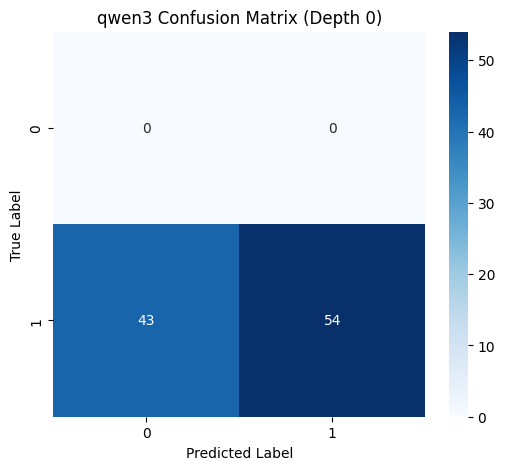


--- Depth: 1 (300 examples) ---
  qwen3 Accuracy: 0.8067


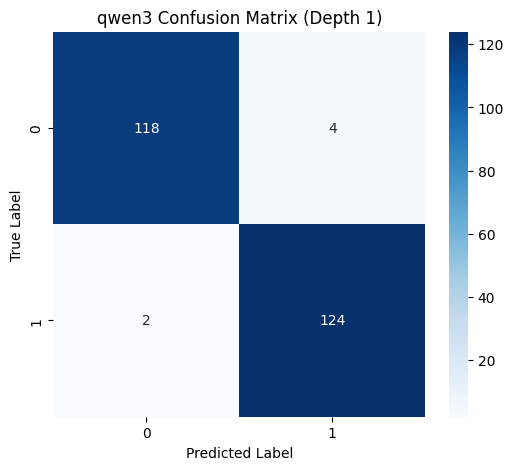


--- Depth: 2 (300 examples) ---
  qwen3 Accuracy: 0.8367


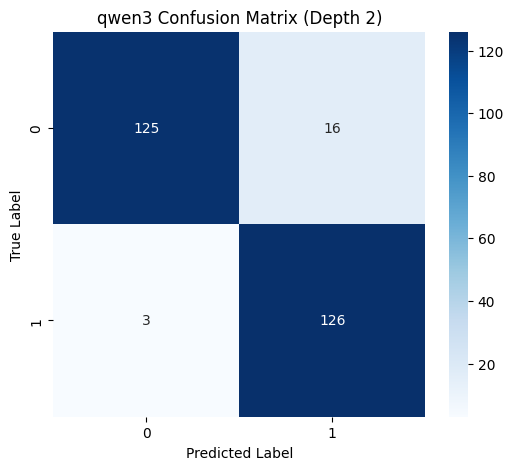


--- Depth: 3 (300 examples) ---
  qwen3 Accuracy: 0.8233


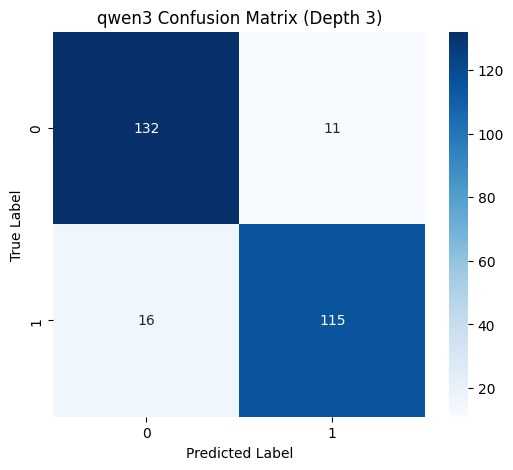


--- Depth: 4 (300 examples) ---
  qwen3 Accuracy: 0.7800


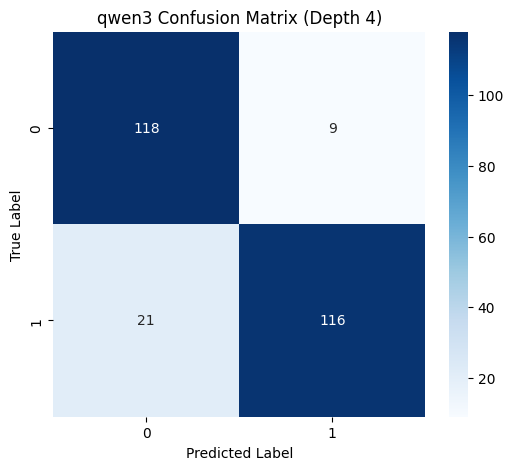


--- Depth: 5 (300 examples) ---
  qwen3 Accuracy: 0.7400


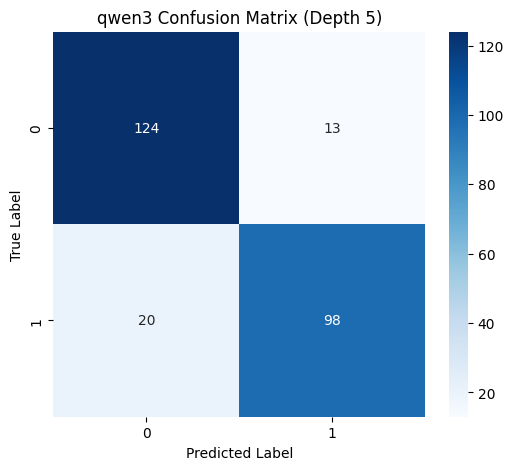


--- Depth: 6 (300 examples) ---
  qwen3 Accuracy: 0.7200


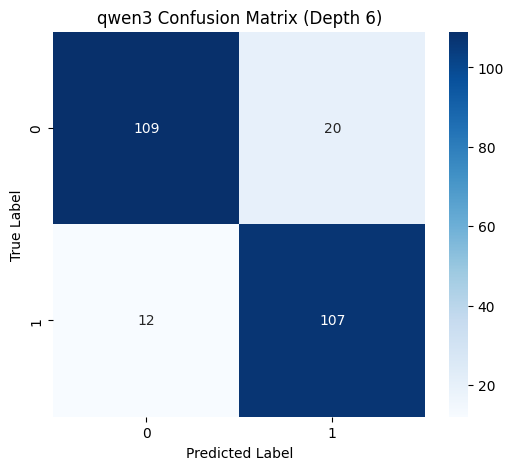


--- Depth: 7 (300 examples) ---
  qwen3 Accuracy: 0.5800


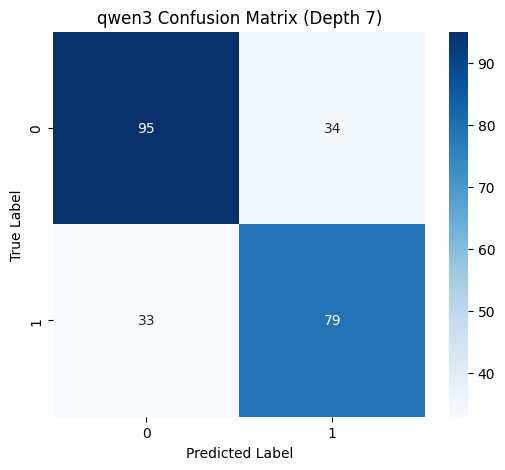


--- Depth: 8 (300 examples) ---
  qwen3 Accuracy: 0.5533


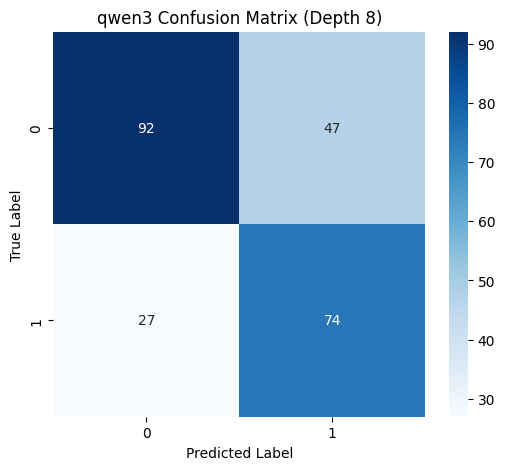


--- Depth: 9 (300 examples) ---
  qwen3 Accuracy: 0.4967


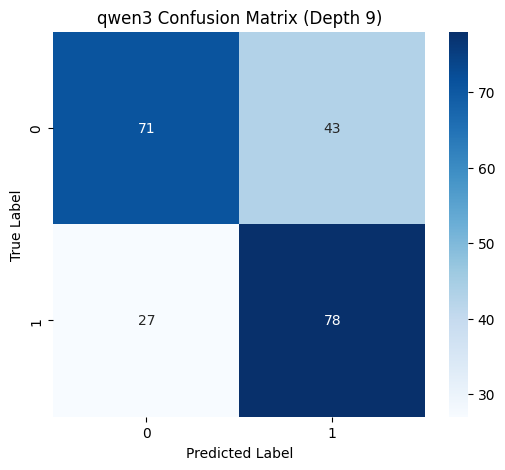


--- Depth: 10 (300 examples) ---
  qwen3 Accuracy: 0.4367


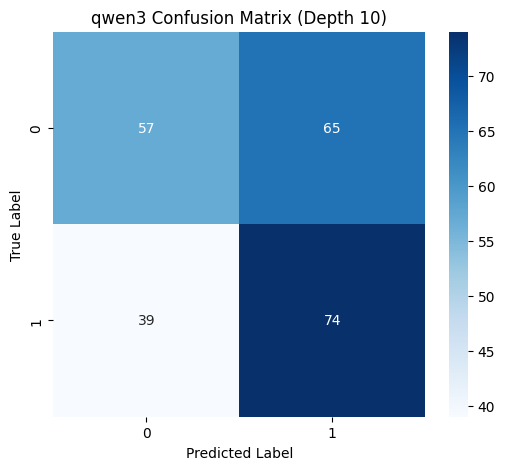


--- Depth: 11 (300 examples) ---
  qwen3 Accuracy: 0.4400


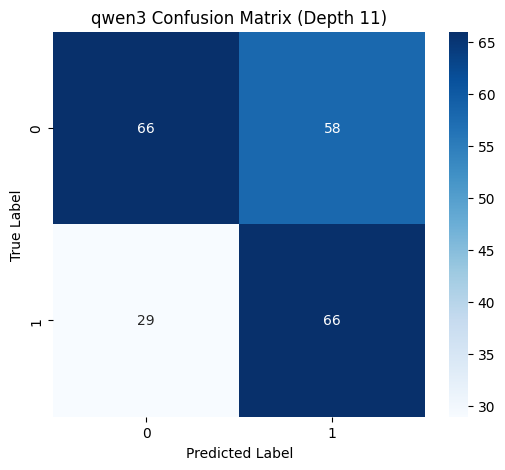

In [71]:
print("\n***** Evaluation Results *****")
accuracy_by_depth = {"depth": list(), "accuracy": list()}
results_by_depth = defaultdict(list)
for res in results: results_by_depth[res['depth']].append(res)
sorted_depths = sorted(results_by_depth.keys())

# --- Overall Accuracy ---
print(f"\nOverall QWEN#-1.7B Accuracy: {accuracy_score(all_true_labels, qwen3_preds):.4f}")

print("\n--- Depth-wise Analysis ---")
for depth in sorted_depths:
    depth_results = results_by_depth[depth]
    true_labels = [r['true_label'] for r in depth_results]
    print(f"\n--- Depth: {depth} ({len(depth_results)} examples) ---")

    model_preds = {
        "qwen3": [r['qwen3_pred'] for r in depth_results] if qwen3_preds else None,
        # LOCAL_COMPARISON_MODEL_ID: [r['local_comp_pred'] for r in depth_results] if local_comp_preds else None,
        # "DeepSeek API": [r['deepseek_api_pred'] for r in depth_results] if deepseek_api_preds else None,
    }

    for name, preds in model_preds.items():
        if preds:
            acc = accuracy_score(true_labels, preds)
            print(f"  {name} Accuracy: {acc:.4f}")
            cm = confusion_matrix(true_labels, preds, labels=[0, 1])
            plot_confusion_matrix(cm, classes=['0', '1'], title=f'{name} Confusion Matrix (Depth {depth})')

            accuracy_by_depth["depth"].append(depth)
            accuracy_by_depth["accuracy"].append(np.round(acc, 4))

In [82]:
qwen_0shot = [0.99, 0.68, 0.44, 0.49, 0.4, 0.4, 0.39, 0.37, 0.33, 0.4, 0.33, 0.41]
qwen_5shot = [0.99, 0.7, 0.45, 0.49, 0.41, 0.4, 0.4, 0.35, 0.32, 0.42, 0.35, 0.4]
qwen3_17B_0shot = [0.96, 0.89, 0.81, 0.69, 0.61, 0.58, 0.56, 0.56, 0.55, 0.52, 0.54, 0.49]
qwen3_1pt7B_finetuned = [0.18, 0.80, 0.83, 0.82, 0.78, 0.74, 0.72, 0.58, 0.55, 0.49, 0.43, 0.44]

In [95]:
import pandas as pd
df = pd.DataFrame(accuracy_by_depth).rename(columns={'depth': 'Depth', 'accuracy': 'Qwen3-1.7B LoRA Finetuned (0.37% trained)'})
print(df.to_string(index=False))

 Depth  Qwen3-1.7B LoRA Finetuned (0.37% trained)
     0                                     0.1800
     1                                     0.8067
     2                                     0.8367
     3                                     0.8233
     4                                     0.7800
     5                                     0.7400
     6                                     0.7200
     7                                     0.5800
     8                                     0.5533
     9                                     0.4967
    10                                     0.4367
    11                                     0.4400


In [96]:
df['qwen-25-vl7b_zero_shot'] = qwen_0shot
df['qwen-25-vl7b_five_shot'] = qwen_0shot

In [97]:
print(df.to_string(index=False))

 Depth  Qwen3-1.7B LoRA Finetuned (0.37% trained)  qwen-25-vl7b_zero_shot  qwen-25-vl7b_five_shot
     0                                     0.1800                    0.99                    0.99
     1                                     0.8067                    0.68                    0.68
     2                                     0.8367                    0.44                    0.44
     3                                     0.8233                    0.49                    0.49
     4                                     0.7800                    0.40                    0.40
     5                                     0.7400                    0.40                    0.40
     6                                     0.7200                    0.39                    0.39
     7                                     0.5800                    0.37                    0.37
     8                                     0.5533                    0.33                    0.33
     9              

In [ ]:
# Merge to 16bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False: # Pushing to HF Hub
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")

In [81]:
hub_repo_id = "causality-grammar/qwen3-1.7B"
print("Pushing model to the Hub...")
# Push the model to the Hub
model.push_to_hub(
    repo_id=hub_repo_id,
    commit_message="Initial model upload"
)

print("Pushing tokenizer to the Hub...")
# Push the tokenizer to the same repository
tokenizer.push_to_hub(
    repo_id=hub_repo_id,
    commit_message="Upload tokenizer"
)

Pushing model to the Hub...


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmp8hgi8il3/model.safetensors    :   0%|          | 16.7MB / 3.44GB            

Saved model to https://huggingface.co/causality-grammar/qwen3-1.7B
Pushing tokenizer to the Hub...


README.md:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmp39sgpp5l/tokenizer.json       :  27%|##7       | 3.13MB / 11.4MB            